In [100]:
library(dplyr)
library(ggplot2)
library(forecast)
library(gridExtra)
library(lubridate)
library(gbm)
library(quantmod)
library(rpart)
library(rpart.plot)
library(randomForest)

## **Reservation Websites:**

1. Hpg -> Hot Pepper Gourmet
<br>
2. air -> AirREGI

In [3]:
air_visit_data <- read.csv('air_visit_data.csv')
air_reserve <- read.csv('air_reserve.csv')
air_store_info <- read.csv('air_store_info.csv') #done
date_info <- read.csv('date_info.csv') # done
sample_submission <- read.csv('sample_submission.csv')
store_id_relation <- read.csv('store_id_relation.csv')

In [4]:
head(air_visit_data)
str(air_visit_data)

air_store_id,visit_date,visitors
air_ba937bf13d40fb24,2016-01-13,25
air_ba937bf13d40fb24,2016-01-14,32
air_ba937bf13d40fb24,2016-01-15,29
air_ba937bf13d40fb24,2016-01-16,22
air_ba937bf13d40fb24,2016-01-18,6
air_ba937bf13d40fb24,2016-01-19,9


'data.frame':	252108 obs. of  3 variables:
 $ air_store_id: Factor w/ 829 levels "air_00a91d42b08b08d9",..: 604 604 604 604 604 604 604 604 604 604 ...
 $ visit_date  : Factor w/ 478 levels "2016-01-01","2016-01-02",..: 13 14 15 16 18 19 20 21 22 23 ...
 $ visitors    : int  25 32 29 22 6 9 31 21 18 26 ...


In [5]:
summary(air_visit_data)

               air_store_id         visit_date        visitors     
 air_5c817ef28f236bdf:   477   2017-03-17:   799   Min.   :  1.00  
 air_36bcf77d3382d36e:   476   2017-03-03:   791   1st Qu.:  9.00  
 air_a083834e7ffe187e:   476   2017-04-14:   791   Median : 17.00  
 air_d97dabf7aae60da5:   476   2017-03-24:   789   Mean   : 20.97  
 air_232dcee6f7c51d37:   475   2017-03-31:   786   3rd Qu.: 29.00  
 air_60a7057184ec7ec7:   475   2017-04-21:   784   Max.   :877.00  
 (Other)             :249253   (Other)   :247368                   

In [6]:
head(air_reserve)
str(air_reserve)

air_store_id,visit_datetime,reserve_datetime,reserve_visitors
air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 16:00:00,2


'data.frame':	92378 obs. of  4 variables:
 $ air_store_id    : Factor w/ 314 levels "air_00a91d42b08b08d9",..: 168 270 270 168 271 271 271 72 72 49 ...
 $ visit_datetime  : Factor w/ 4975 levels "2016-01-01 19:00:00",..: 1 1 1 2 2 3 3 4 4 5 ...
 $ reserve_datetime: Factor w/ 7513 levels "2016-01-01 01:00:00",..: 6 8 8 6 1 6 5 17 9 20 ...
 $ reserve_visitors: int  1 3 6 2 5 2 4 2 2 2 ...


In [7]:
air_reserve$visit_date <- as.Date(air_reserve$visit_datetime)
air_reserve$reserve_visitors_air <- air_reserve$reserve_visitors
air_reserve$visit_datetime_air <- air_reserve$visit_datetime
air_reserve$reserve_datetime_air <- air_reserve$reserve_datetime
air_reserve$reserve_visitors <-NULL
air_reserve$visit_datetime <-NULL
air_reserve$reserve_datetime <-NULL

In [8]:
str(air_reserve)

'data.frame':	92378 obs. of  5 variables:
 $ air_store_id        : Factor w/ 314 levels "air_00a91d42b08b08d9",..: 168 270 270 168 271 271 271 72 72 49 ...
 $ visit_date          : Date, format: "2016-01-01" "2016-01-01" ...
 $ reserve_visitors_air: int  1 3 6 2 5 2 4 2 2 2 ...
 $ visit_datetime_air  : Factor w/ 4975 levels "2016-01-01 19:00:00",..: 1 1 1 2 2 3 3 4 4 5 ...
 $ reserve_datetime_air: Factor w/ 7513 levels "2016-01-01 01:00:00",..: 6 8 8 6 1 6 5 17 9 20 ...


In [9]:
air_store_info$latitude <- NULL
air_store_info$longitude <- NULL
head(air_store_info)
str(air_store_info)

air_store_id,air_genre_name,air_area_name
air_0f0cdeee6c9bf3d7,Italian/French,HyÅgo-ken KÅbe-shi KumoidÅri
air_7cc17a324ae5c7dc,Italian/French,HyÅgo-ken KÅbe-shi KumoidÅri
air_fee8dcf4d619598e,Italian/French,HyÅgo-ken KÅbe-shi KumoidÅri
air_a17f0778617c76e2,Italian/French,HyÅgo-ken KÅbe-shi KumoidÅri
air_83db5aff8f50478e,Italian/French,TÅkyÅ-to Minato-ku ShibakÅen
air_99c3eae84130c1cb,Italian/French,TÅkyÅ-to Minato-ku ShibakÅen


'data.frame':	829 obs. of  3 variables:
 $ air_store_id  : Factor w/ 829 levels "air_00a91d42b08b08d9",..: 43 391 826 528 413 500 789 342 32 131 ...
 $ air_genre_name: Factor w/ 14 levels "Asian","Bar/Cocktail",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ air_area_name : Factor w/ 103 levels "ÅŒsaka-fu ÅŒsaka-shi ÅŒgimachi",..: 39 39 39 39 77 77 77 77 77 77 ...


In [10]:
head(date_info)
str(date_info)

calendar_date,day_of_week,holiday_flg
2016-01-01,Friday,1
2016-01-02,Saturday,1
2016-01-03,Sunday,1
2016-01-04,Monday,0
2016-01-05,Tuesday,0
2016-01-06,Wednesday,0


'data.frame':	517 obs. of  3 variables:
 $ calendar_date: Factor w/ 517 levels "2016-01-01","2016-01-02",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ day_of_week  : Factor w/ 7 levels "Friday","Monday",..: 1 3 4 2 6 7 5 1 3 4 ...
 $ holiday_flg  : int  1 1 1 0 0 0 0 0 0 0 ...


In [12]:
head(store_id_relation)
str(store_id_relation)

air_store_id,hpg_store_id
air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
air_a24bf50c3e90d583,hpg_c34b496d0305a809
air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
air_965b2e0cf4119003,hpg_653238a84804d8e7
air_a38f25e3399d1b25,hpg_50378da9ffb9b6cd


'data.frame':	150 obs. of  2 variables:
 $ air_store_id: Factor w/ 150 levels "air_00a91d42b08b08d9",..: 57 97 120 88 90 98 33 61 53 1 ...
 $ hpg_store_id: Factor w/ 150 levels "hpg_0183ec352e38903c",..: 51 116 121 131 66 56 41 29 47 149 ...


In [13]:
head(sample_submission)
str(sample_submission)

id,visitors
air_00a91d42b08b08d9_2017-04-23,0
air_00a91d42b08b08d9_2017-04-24,0
air_00a91d42b08b08d9_2017-04-25,0
air_00a91d42b08b08d9_2017-04-26,0
air_00a91d42b08b08d9_2017-04-27,0
air_00a91d42b08b08d9_2017-04-28,0


'data.frame':	32019 obs. of  2 variables:
 $ id      : Factor w/ 32019 levels "air_00a91d42b08b08d9_2017-04-23",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ visitors: int  0 0 0 0 0 0 0 0 0 0 ...


# Combined data

In [14]:
# combining the data frame with common columns
air_visit_data1 <- left_join(air_visit_data, air_store_info, by = c('air_store_id' = 'air_store_id'))
air_visit_data2 <- left_join(air_visit_data1, date_info, by = c('visit_date' = 'calendar_date'))
air_visit_data2 <- mutate(air_visit_data2, holiday_flg = ifelse(holiday_flg == 0, 'No_holiday', 'Holiday'))
air_visit_data2$holiday_flg <- as.factor(air_visit_data2$holiday_flg)
air_visit_data2$visit_date <- as.Date(air_visit_data2$visit_date)
head(air_visit_data2)
str(air_visit_data2)

Warning message:
"Column `visit_date`/`calendar_date` joining factors with different levels, coercing to character vector"

air_store_id,visit_date,visitors,air_genre_name,air_area_name,day_of_week,holiday_flg
air_ba937bf13d40fb24,2016-01-13,25,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Wednesday,No_holiday
air_ba937bf13d40fb24,2016-01-14,32,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Thursday,No_holiday
air_ba937bf13d40fb24,2016-01-15,29,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Friday,No_holiday
air_ba937bf13d40fb24,2016-01-16,22,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Saturday,No_holiday
air_ba937bf13d40fb24,2016-01-18,6,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Monday,No_holiday
air_ba937bf13d40fb24,2016-01-19,9,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Tuesday,No_holiday


'data.frame':	252108 obs. of  7 variables:
 $ air_store_id  : Factor w/ 829 levels "air_00a91d42b08b08d9",..: 604 604 604 604 604 604 604 604 604 604 ...
 $ visit_date    : Date, format: "2016-01-13" "2016-01-14" ...
 $ visitors      : int  25 32 29 22 6 9 31 21 18 26 ...
 $ air_genre_name: Factor w/ 14 levels "Asian","Bar/Cocktail",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ air_area_name : Factor w/ 103 levels "ÅŒsaka-fu ÅŒsaka-shi ÅŒgimachi",..: 77 77 77 77 77 77 77 77 77 77 ...
 $ day_of_week   : Factor w/ 7 levels "Friday","Monday",..: 7 5 1 3 2 6 7 5 1 3 ...
 $ holiday_flg   : Factor w/ 2 levels "Holiday","No_holiday": 2 2 2 2 2 2 2 2 2 2 ...


In [15]:
summary(air_visit_data2)

               air_store_id      visit_date            visitors     
 air_5c817ef28f236bdf:   477   Min.   :2016-01-01   Min.   :  1.00  
 air_36bcf77d3382d36e:   476   1st Qu.:2016-07-23   1st Qu.:  9.00  
 air_a083834e7ffe187e:   476   Median :2016-10-23   Median : 17.00  
 air_d97dabf7aae60da5:   476   Mean   :2016-10-12   Mean   : 20.97  
 air_232dcee6f7c51d37:   475   3rd Qu.:2017-01-24   3rd Qu.: 29.00  
 air_60a7057184ec7ec7:   475   Max.   :2017-04-22   Max.   :877.00  
 (Other)             :249253                                        
        air_genre_name                            air_area_name   
 Izakaya       :62052   Fukuoka-ken Fukuoka-shi DaimyÅ\215  : 19775  
 Cafe/Sweets   :52764   TÅ\215kyÅ\215-to Shibuya-ku Shibuya    : 17352  
 Dining bar    :34192   TÅ\215kyÅ\215-to Minato-ku ShibakÅ\215en  : 14696  
 Italian/French:30011   TÅ\215kyÅ\215-to Shinjuku-ku KabukichÅ\215: 12517  
 Bar/Cocktail  :25135   TÅ\215kyÅ\215-to Setagaya-ku Setagaya  :  8719  
 Japanese foo

In [16]:
head(air_reserve)
str(air_reserve)

air_store_id,visit_date,reserve_visitors_air,visit_datetime_air,reserve_datetime_air
air_877f79706adbfb06,2016-01-01,1,2016-01-01 19:00:00,2016-01-01 16:00:00
air_db4b38ebe7a7ceff,2016-01-01,3,2016-01-01 19:00:00,2016-01-01 19:00:00
air_db4b38ebe7a7ceff,2016-01-01,6,2016-01-01 19:00:00,2016-01-01 19:00:00
air_877f79706adbfb06,2016-01-01,2,2016-01-01 20:00:00,2016-01-01 16:00:00
air_db80363d35f10926,2016-01-01,5,2016-01-01 20:00:00,2016-01-01 01:00:00
air_db80363d35f10926,2016-01-02,2,2016-01-02 01:00:00,2016-01-01 16:00:00


'data.frame':	92378 obs. of  5 variables:
 $ air_store_id        : Factor w/ 314 levels "air_00a91d42b08b08d9",..: 168 270 270 168 271 271 271 72 72 49 ...
 $ visit_date          : Date, format: "2016-01-01" "2016-01-01" ...
 $ reserve_visitors_air: int  1 3 6 2 5 2 4 2 2 2 ...
 $ visit_datetime_air  : Factor w/ 4975 levels "2016-01-01 19:00:00",..: 1 1 1 2 2 3 3 4 4 5 ...
 $ reserve_datetime_air: Factor w/ 7513 levels "2016-01-01 01:00:00",..: 6 8 8 6 1 6 5 17 9 20 ...


In [17]:
summary(air_reserve)

               air_store_id     visit_date         reserve_visitors_air
 air_8093d0b565e9dbdf: 2263   Min.   :2016-01-01   Min.   :  1.000     
 air_e55abd740f93ecc4: 1903   1st Qu.:2016-11-15   1st Qu.:  2.000     
 air_0a74a5408a0b8642: 1831   Median :2017-01-05   Median :  3.000     
 air_cf5ab75a0afb8af9: 1758   Mean   :2016-12-04   Mean   :  4.482     
 air_6d65542aa43b598b: 1436   3rd Qu.:2017-03-03   3rd Qu.:  5.000     
 air_de692863bb2dd758: 1355   Max.   :2017-05-31   Max.   :100.000     
 (Other)             :81832                                            
           visit_datetime_air          reserve_datetime_air
 2016-12-24 19:00:00:  255    2016-11-24 18:00:00:  106    
 2016-12-29 18:00:00:  230    2016-12-24 17:00:00:  103    
 2016-12-17 18:00:00:  229    2016-12-08 18:00:00:   95    
 2016-12-24 18:00:00:  227    2016-12-06 19:00:00:   92    
 2017-02-04 19:00:00:  226    2016-12-07 17:00:00:   91    
 2016-12-10 18:00:00:  219    2017-03-09 18:00:00:   90    
 (Ot

In [18]:
air_visit_data3 <- left_join(air_visit_data2, air_reserve, by = c('air_store_id' = 'air_store_id', 'visit_date' = 'visit_date'))

Warning message:
"Column `air_store_id` joining factors with different levels, coercing to character vector"

In [19]:
head(air_visit_data3)
str(air_visit_data3)

air_store_id,visit_date,visitors,air_genre_name,air_area_name,day_of_week,holiday_flg,reserve_visitors_air,visit_datetime_air,reserve_datetime_air
air_ba937bf13d40fb24,2016-01-13,25,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Wednesday,No_holiday,NA,NA,NA
air_ba937bf13d40fb24,2016-01-14,32,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Thursday,No_holiday,NA,NA,NA
air_ba937bf13d40fb24,2016-01-15,29,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Friday,No_holiday,NA,NA,NA
air_ba937bf13d40fb24,2016-01-16,22,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Saturday,No_holiday,NA,NA,NA
air_ba937bf13d40fb24,2016-01-18,6,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Monday,No_holiday,NA,NA,NA
air_ba937bf13d40fb24,2016-01-19,9,Dining bar,TÅkyÅ-to Minato-ku ShibakÅen,Tuesday,No_holiday,NA,NA,NA


'data.frame':	311225 obs. of  10 variables:
 $ air_store_id        : chr  "air_ba937bf13d40fb24" "air_ba937bf13d40fb24" "air_ba937bf13d40fb24" "air_ba937bf13d40fb24" ...
 $ visit_date          : Date, format: "2016-01-13" "2016-01-14" ...
 $ visitors            : int  25 32 29 22 6 9 31 21 18 26 ...
 $ air_genre_name      : Factor w/ 14 levels "Asian","Bar/Cocktail",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ air_area_name       : Factor w/ 103 levels "ÅŒsaka-fu ÅŒsaka-shi ÅŒgimachi",..: 77 77 77 77 77 77 77 77 77 77 ...
 $ day_of_week         : Factor w/ 7 levels "Friday","Monday",..: 7 5 1 3 2 6 7 5 1 3 ...
 $ holiday_flg         : Factor w/ 2 levels "Holiday","No_holiday": 2 2 2 2 2 2 2 2 2 2 ...
 $ reserve_visitors_air: int  NA NA NA NA NA NA NA NA NA NA ...
 $ visit_datetime_air  : Factor w/ 4975 levels "2016-01-01 19:00:00",..: NA NA NA NA NA NA NA NA NA NA ...
 $ reserve_datetime_air: Factor w/ 7513 levels "2016-01-01 01:00:00",..: NA NA NA NA NA NA NA NA NA NA ...


In [20]:
summary(air_visit_data3)

 air_store_id         visit_date            visitors     
 Length:311225      Min.   :2016-01-01   Min.   :  1.00  
 Class :character   1st Qu.:2016-07-29   1st Qu.: 10.00  
 Mode  :character   Median :2016-11-13   Median : 20.00  
                    Mean   :2016-10-22   Mean   : 23.79  
                    3rd Qu.:2017-02-04   3rd Qu.: 33.00  
                    Max.   :2017-04-22   Max.   :877.00  
                                                         
        air_genre_name                                     air_area_name   
 Izakaya       :83883   Fukuoka-ken Fukuoka-shi DaimyÅ\215           : 22742  
 Cafe/Sweets   :54874   TÅ\215kyÅ\215-to Shibuya-ku Shibuya             : 21024  
 Italian/French:43637   TÅ\215kyÅ\215-to Minato-ku ShibakÅ\215en           : 16712  
 Dining bar    :38825   TÅ\215kyÅ\215-to Shinjuku-ku KabukichÅ\215         : 14921  
 Japanese food :25440   Hiroshima-ken Hiroshima-shi Kokutaijimachi: 10766  
 Bar/Cocktail  :25373   HokkaidÅ\215 Sapporo-shi Mina

In [21]:
air_visit_data4 <- na.omit(air_visit_data3)

In [22]:
air_visit_data4$unreserved_visitors <- (air_visit_data4$visitors -(air_visit_data4$reserve_visitors_air))
air_visit_data4$reserved_visitors <- air_visit_data4$visitors - air_visit_data4$unreserved_visitors
air_visit_data4$time_gap_in_hours <- as.numeric(difftime(air_visit_data4$visit_datetime_air,air_visit_data4$reserve_datetime_air), units = 'hours')

In [23]:
breaks <- hour(hm("00:00", "8:00", "2:00", "18:00", "23:59")) # create breaks
labels <- c("Morning", "Afternoon", "Evening", "Night") # labels for the breaks
air_visit_data4$Time_of_day <- cut(x=hour(air_visit_data4$visit_datetime_air), breaks = breaks, labels = labels, include.lowest= TRUE)

In [24]:
air_visit_data4$reserve_datetime_air <- as.POSIXct(air_visit_data4$reserve_datetime_air)
air_visit_data4$visit_month <-  months.Date(air_visit_data4$visit_date)
air_visit_data4$r_month_air <-  months.Date(air_visit_data4$reserve_datetime_air)

In [25]:
air_visit_data4$reserve_visitors_air <- NULL

In [26]:
head(air_visit_data4)
str(air_visit_data4)

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,day_of_week,holiday_flg,visit_datetime_air,reserve_datetime_air,unreserved_visitors,reserved_visitors,time_gap_in_hours,Time_of_day,visit_month,r_month_air
1007,air_35512c42db0868da,2016-02-27,6,Dining bar,TÅkyÅ-to Musashino-shi MidorichÅ,Saturday,No_holiday,2016-02-27 22:00:00,2016-02-27,-6,12,0,Night,February,February
3745,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Monday,No_holiday,2016-01-04 15:00:00,2016-01-04,59,2,0,Evening,January,January
3748,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Friday,No_holiday,2016-01-08 19:00:00,2016-01-06,18,3,48,Night,January,January
3749,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Saturday,No_holiday,2016-01-09 11:00:00,2016-01-06,56,1,72,Evening,January,January
3750,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Saturday,No_holiday,2016-01-09 11:00:00,2016-01-07,55,2,48,Evening,January,January
3751,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Saturday,No_holiday,2016-01-09 11:00:00,2016-01-08,54,3,24,Evening,January,January


'data.frame':	87181 obs. of  15 variables:
 $ air_store_id        : chr  "air_35512c42db0868da" "air_ee3a01f0c71a769f" "air_ee3a01f0c71a769f" "air_ee3a01f0c71a769f" ...
 $ visit_date          : Date, format: "2016-02-27" "2016-01-04" ...
 $ visitors            : int  6 61 21 57 57 57 57 57 57 57 ...
 $ air_genre_name      : Factor w/ 14 levels "Asian","Bar/Cocktail",..: 5 3 3 3 3 3 3 3 3 3 ...
 $ air_area_name       : Factor w/ 103 levels "ÅŒsaka-fu ÅŒsaka-shi ÅŒgimachi",..: 79 50 50 50 50 50 50 50 50 50 ...
 $ day_of_week         : Factor w/ 7 levels "Friday","Monday",..: 3 2 1 3 3 3 3 3 3 3 ...
 $ holiday_flg         : Factor w/ 2 levels "Holiday","No_holiday": 2 2 2 2 2 2 2 2 2 2 ...
 $ visit_datetime_air  : Factor w/ 4975 levels "2016-01-01 19:00:00",..: 621 17 59 67 67 67 69 69 70 71 ...
 $ reserve_datetime_air: POSIXct, format: "2016-02-27" "2016-01-04" ...
 $ unreserved_visitors : int  -6 59 18 56 55 54 55 55 55 55 ...
 $ reserved_visitors   : int  12 2 3 1 2 3 2 2 2 2 ...
 $ ti

In [27]:
air_visit_data4$air_store_id <- as.factor(air_visit_data4$air_store_id)
air_visit_data4$visit_month <- as.factor(air_visit_data4$visit_month)
air_visit_data4$r_month_air <- as.factor(air_visit_data4$r_month_air)

In [28]:
summary(air_visit_data4)

               air_store_id     visit_date            visitors     
 air_8093d0b565e9dbdf: 2229   Min.   :2016-01-01   Min.   :  1.00  
 air_e55abd740f93ecc4: 1875   1st Qu.:2016-11-13   1st Qu.: 18.00  
 air_0a74a5408a0b8642: 1818   Median :2017-01-02   Median : 29.00  
 air_6d65542aa43b598b: 1410   Mean   :2016-11-30   Mean   : 32.83  
 air_de692863bb2dd758: 1342   3rd Qu.:2017-03-01   3rd Qu.: 44.00  
 air_326ca454ef3558bc: 1257   Max.   :2017-04-22   Max.   :239.00  
 (Other)             :77250                                        
              air_genre_name 
 Izakaya             :31610  
 Italian/French      :19697  
 Japanese food       : 9727  
 Dining bar          : 8039  
 Yakiniku/Korean food: 5616  
 Western food        : 4084  
 (Other)             : 8408  
                                    air_area_name      day_of_week   
 TÅ\215kyÅ\215-to Shibuya-ku Shibuya             : 5830   Friday   :18677  
 HokkaidÅ\215 Sapporo-shi Minami 3 JÅ\215nishi   : 5556   Monday   : 7

# Visualization

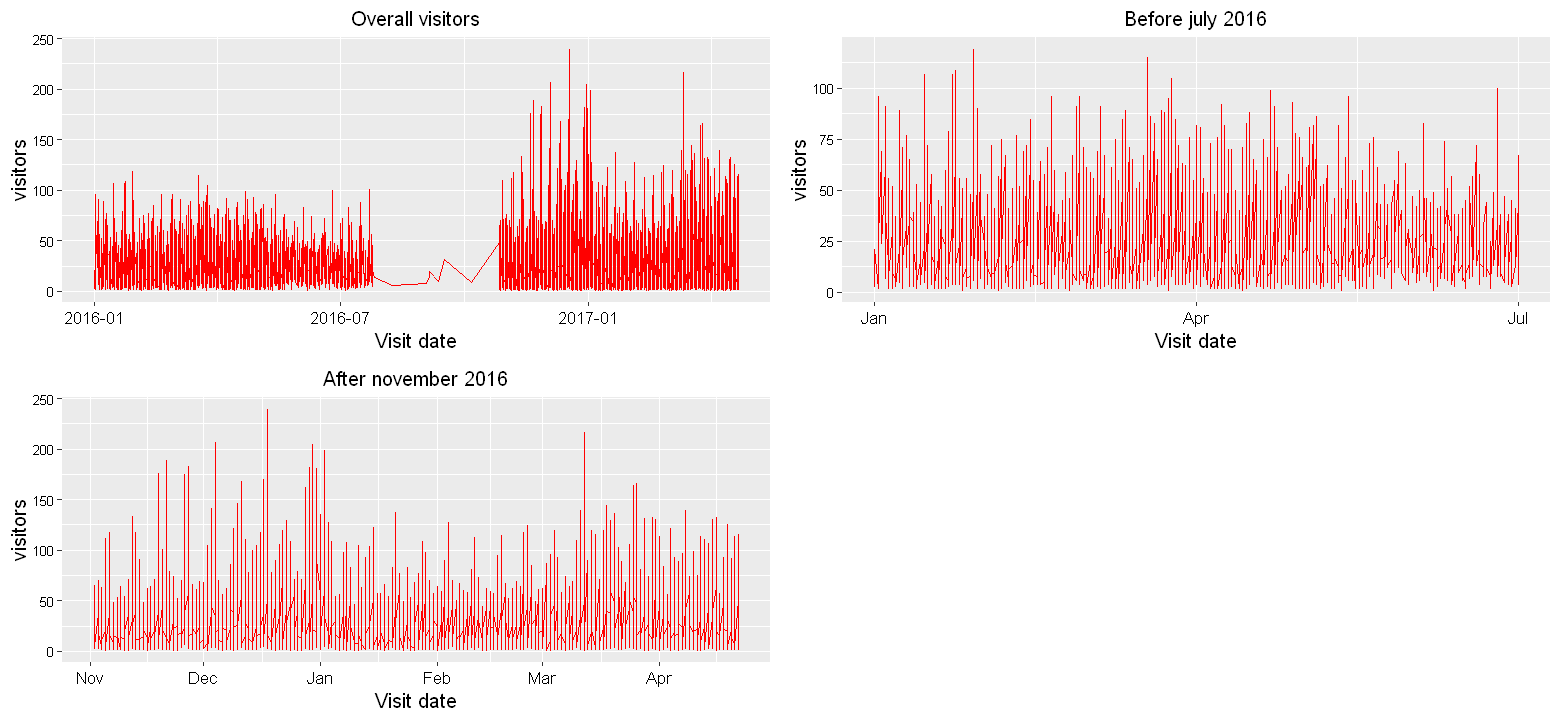

In [29]:
options(repr.plot.width = 13, repr.plot.height = 6)
plot1 <- ggplot(air_visit_data4, aes(x = visit_date, y= visitors)) +
         geom_line(col = 'red') +
         labs( x = 'Visit date', y = 'visitors', title = 'Overall visitors') +
         theme(plot.title = element_text(hjust = 0.5, size = 12),
         axis.title = element_text(size = 12),
         axis.text.x = element_text(size = 10),
         axis.text.y = element_text(size = 8),
         axis.text = element_text(colour = 'black'))
 
plot2 <- ggplot(air_visit_data4 %>% filter(visit_date <= '2016-07-01'), aes(x = visit_date, y= visitors)) + # before september 20, 2016
         geom_line(col = 'red') +
         labs( x = 'Visit date', y = 'visitors', title = 'Before july 2016') +
         theme(plot.title = element_text(hjust = 0.5, size = 12),
         axis.title = element_text(size = 12),
         axis.text.x = element_text(size = 10),
         axis.text.y = element_text(size = 8),
         axis.text = element_text(colour = 'black'))

plot3 <- ggplot(air_visit_data4 %>% filter(visit_date > '2016-11-01') , aes(x = visit_date, y= visitors)) + # after september 20, 2016
         geom_line(col = 'red') +
         labs( x = 'Visit date', y = 'visitors', title = 'After november 2016') +
         theme(plot.title = element_text(hjust = 0.5, size = 12),
         axis.title = element_text(size = 12),
         axis.text.x = element_text(size = 10),
         axis.text.y = element_text(size = 8),
         axis.text = element_text(colour = 'black'))

grid.arrange(plot1, plot2,plot3, nrow = 2, ncol = 2)

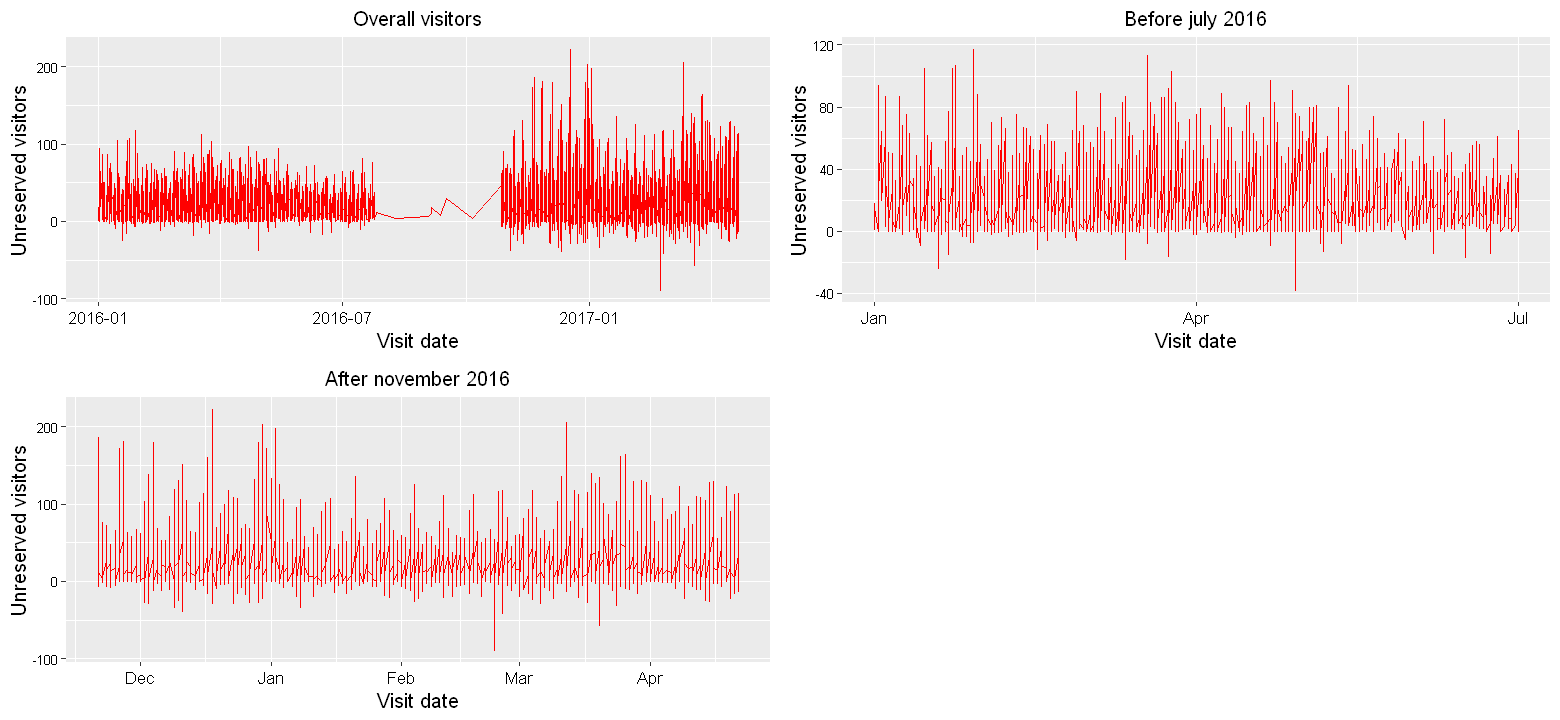

In [30]:
options(repr.plot.width = 13, repr.plot.height = 6)
plot1 <- ggplot(air_visit_data4, aes(x = visit_date, y= unreserved_visitors)) +
         geom_line(col = 'red') +
         labs( x = 'Visit date', y = 'Unreserved visitors', title = 'Overall visitors') +
         theme(plot.title = element_text(hjust = 0.5, size = 12),
         axis.title = element_text(size = 12),
         axis.text.x = element_text(size = 10),
         axis.text.y = element_text(size = 8),
         axis.text = element_text(colour = 'black'))
 
plot2 <- ggplot(air_visit_data4 %>% filter(visit_date <= '2016-07-01'), aes(x = visit_date, y= unreserved_visitors)) + # before september 20, 2016
         geom_line(col = 'red') +
         labs( x = 'Visit date', y = 'Unreserved visitors', title = 'Before july 2016') +
         theme(plot.title = element_text(hjust = 0.5, size = 12),
         axis.title = element_text(size = 12),
         axis.text.x = element_text(size = 10),
         axis.text.y = element_text(size = 8),
         axis.text = element_text(colour = 'black'))

plot3 <- ggplot(air_visit_data4 %>% filter(visit_date > '2016-11-20') , aes(x = visit_date, y= unreserved_visitors)) + # after september 20, 2016
         geom_line(col = 'red') +
         labs( x = 'Visit date', y = 'Unreserved visitors', title = 'After november 2016') +
         theme(plot.title = element_text(hjust = 0.5, size = 12),
         axis.title = element_text(size = 12),
         axis.text.x = element_text(size = 10),
         axis.text.y = element_text(size = 8),
         axis.text = element_text(colour = 'black'))

grid.arrange(plot1, plot2,plot3, nrow = 2, ncol = 2)

**Negative values in the unresereved visitors column indicates people not showing up to restaurant after reserving the place**

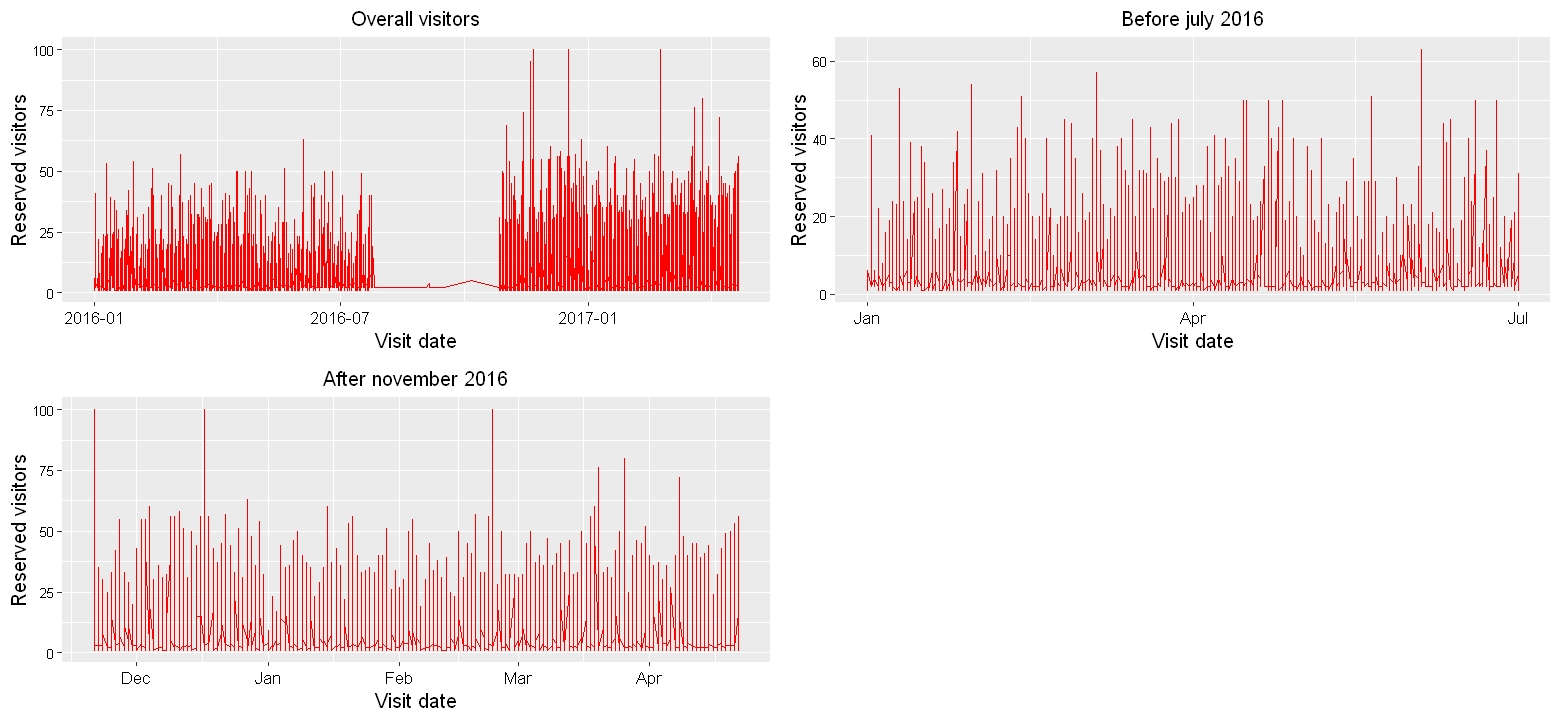

In [31]:
options(repr.plot.width = 13, repr.plot.height = 6)
plot1 <- ggplot(air_visit_data4, aes(x = visit_date, y= reserved_visitors)) +
         geom_line(col = 'red') +
         labs( x = 'Visit date', y = 'Reserved visitors', title = 'Overall visitors') +
         theme(plot.title = element_text(hjust = 0.5, size = 12),
         axis.title = element_text(size = 12),
         axis.text.x = element_text(size = 10),
         axis.text.y = element_text(size = 8),
         axis.text = element_text(colour = 'black'))
 
plot2 <- ggplot(air_visit_data4 %>% filter(visit_date <= '2016-07-01'), aes(x = visit_date, y= reserved_visitors)) + # before september 20, 2016
         geom_line(col = 'red') +
         labs( x = 'Visit date', y = 'Reserved visitors', title = 'Before july 2016') +
         theme(plot.title = element_text(hjust = 0.5, size = 12),
         axis.title = element_text(size = 12),
         axis.text.x = element_text(size = 10),
         axis.text.y = element_text(size = 8),
         axis.text = element_text(colour = 'black'))

plot3 <- ggplot(air_visit_data4 %>% filter(visit_date > '2016-11-20') , aes(x = visit_date, y= reserved_visitors)) + # after september 20, 2016
         geom_line(col = 'red') +
         labs( x = 'Visit date', y = 'Reserved visitors', title = 'After november 2016') +
         theme(plot.title = element_text(hjust = 0.5, size = 12),
         axis.title = element_text(size = 12),
         axis.text.x = element_text(size = 10),
         axis.text.y = element_text(size = 8),
         axis.text = element_text(colour = 'black'))

grid.arrange(plot1, plot2,plot3, nrow = 2, ncol = 2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


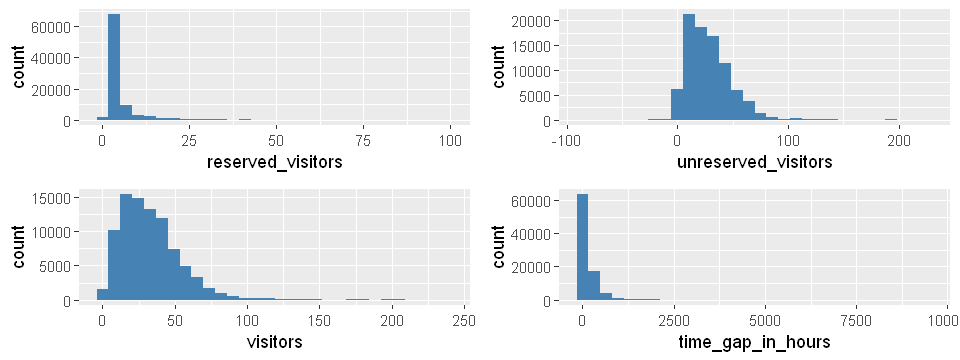

In [32]:
options(repr.plot.width = 8, repr.plot.height = 3)

plot1 <- ggplot(air_visit_data4, aes(reserved_visitors)) +
         geom_histogram(fill = 'steelblue')
plot2 <- ggplot(air_visit_data4, aes(unreserved_visitors)) +
         geom_histogram(fill = 'steelblue')
plot3 <- ggplot(air_visit_data4, aes(visitors)) +
         geom_histogram(fill = 'steelblue')
plot4 <- ggplot(air_visit_data4, aes(time_gap_in_hours)) +
         geom_histogram(fill = 'steelblue')

grid.arrange(plot1, plot2,plot3,plot4, nrow = 2, ncol = 2)

**Above graphs shows the difference between the relationship between time gap (hpg reserve) vs visitors with and without outlier data**

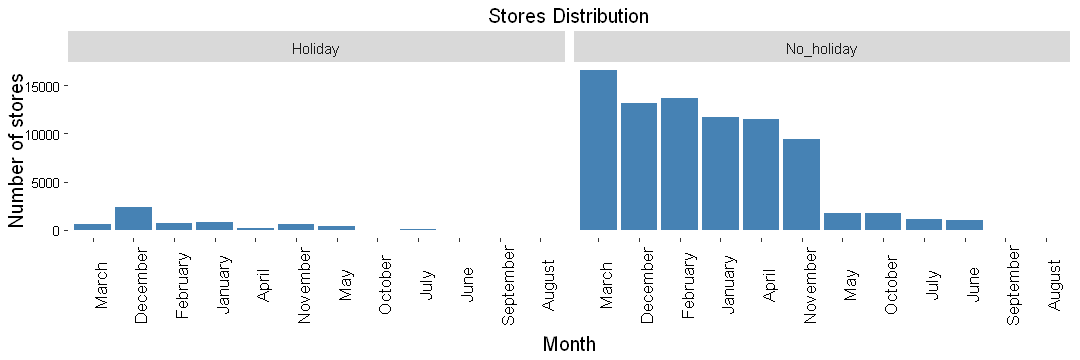

In [33]:
options(repr.plot.width = 9, repr.plot.height = 3)
g3 <- air_visit_data4 %>% group_by(Month = months.Date(visit_date))
ggplot(g3, aes(reorder(Month,Month,function(x)-length(x)))) +
geom_bar(fill = 'steelblue') +
labs( x = 'Month', y = 'Number of stores', title = 'Stores Distribution') +
theme(plot.title = element_text(hjust = 0.5, size = 12),
axis.title = element_text(size = 12),
axis.text.x = element_text(angle = 90, size = 10),
axis.text.y = element_text(size = 8),
panel.grid = element_blank(),
panel.background = element_blank(),
axis.text = element_text(colour = 'black')) +
facet_wrap(~holiday_flg)

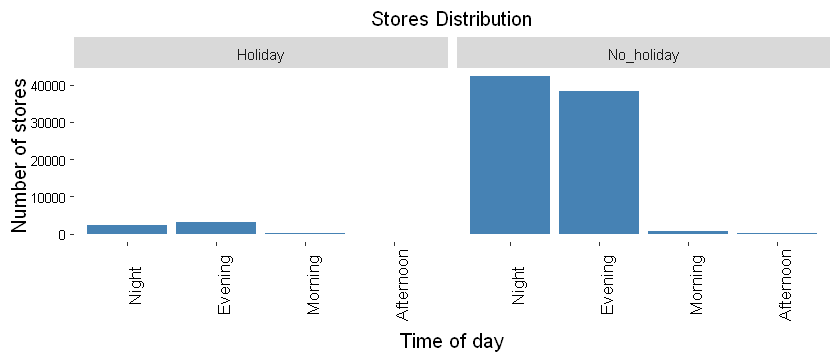

In [34]:
options(repr.plot.width = 7, repr.plot.height = 3)
g1 <- air_visit_data4 %>% group_by(visit_date)
ggplot(g1, aes(reorder(Time_of_day,Time_of_day,function(x)-length(x)))) +
geom_bar(fill = 'steelblue') +
labs( x = 'Time of day', y = 'Number of stores', title = 'Stores Distribution') +
theme(plot.title = element_text(hjust = 0.5, size = 12),
axis.title = element_text(size = 12),
axis.text.x = element_text(angle = 90, size = 10),
axis.text.y = element_text(size = 8),
panel.grid = element_blank(),
panel.background = element_blank(),
axis.text = element_text(colour = 'black')) +
facet_wrap(~holiday_flg)

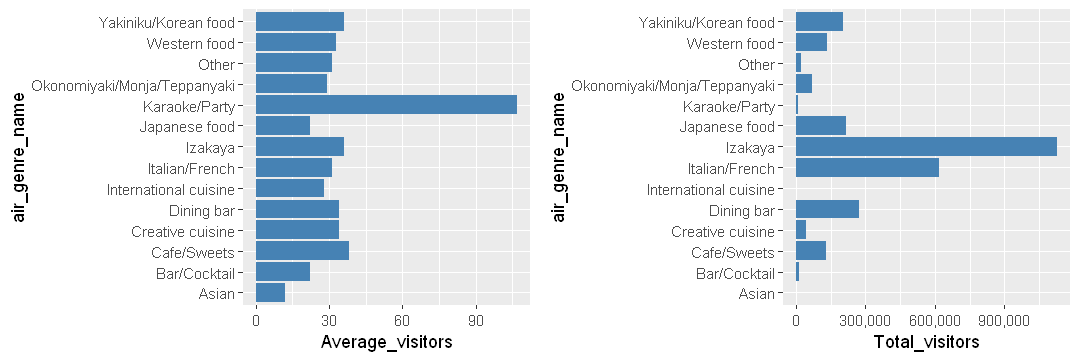

In [35]:
options(repr.plot.width = 9, repr.plot.height = 3)

plot1 <- ggplot(air_visit_data4 %>% group_by(air_genre_name) %>% summarise(Average_visitors = round(mean(visitors))) , 
                aes(air_genre_name, Average_visitors)) +
         geom_bar(stat = "identity",fill = 'steelblue') +
         coord_flip()

plot2 <- ggplot(air_visit_data4 %>% group_by(air_genre_name) %>% summarise(Total_visitors = sum(visitors)), aes(air_genre_name, Total_visitors)) +
         geom_bar(stat = "identity",fill = 'steelblue') +
         scale_y_continuous(labels = scales::comma) +
         coord_flip() 

grid.arrange(plot1, plot2, nrow = 1, ncol = 2)

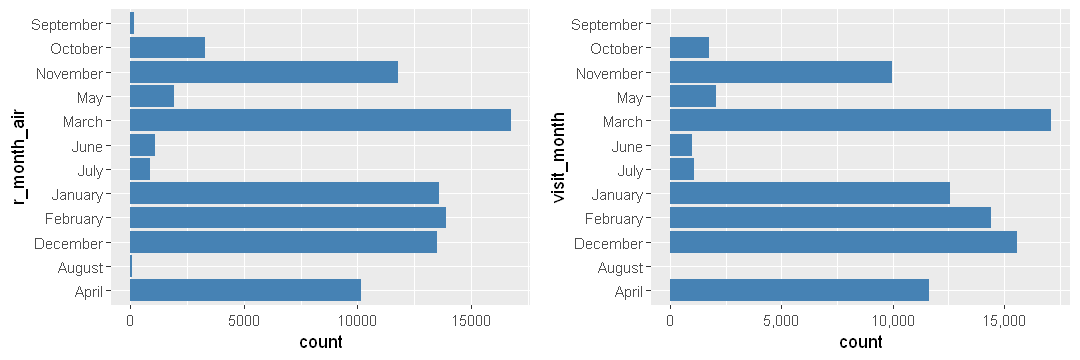

In [36]:
options(repr.plot.width = 9, repr.plot.height = 3)

plot1 <- ggplot(air_visit_data4, aes(r_month_air)) +
         geom_bar(fill = 'steelblue') +
         coord_flip()
plot2 <- ggplot(air_visit_data4, aes(visit_month)) +
         geom_bar(fill = 'steelblue') +
         scale_y_continuous(labels = scales::comma) +
         coord_flip() 

grid.arrange(plot1, plot2, nrow = 1, ncol = 2)

**Japanese people are not visiting the restaurant in the month of august and september** 

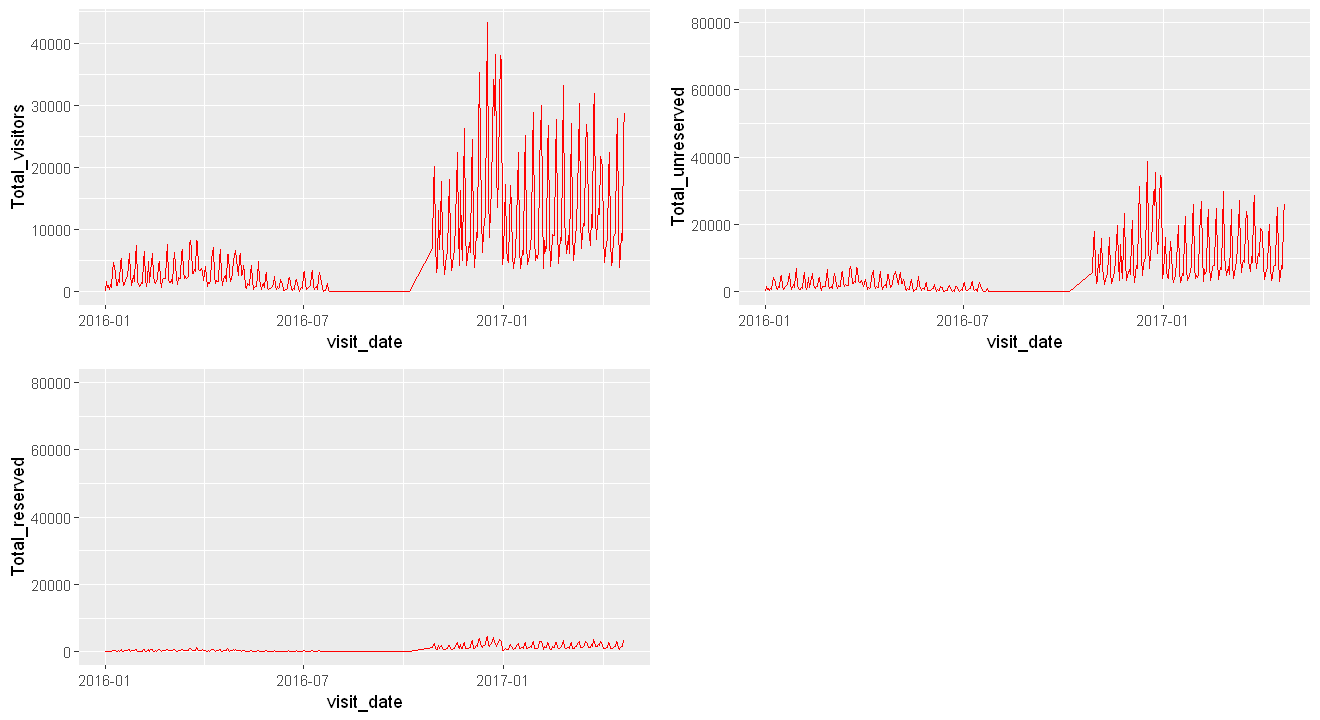

In [37]:
options(repr.plot.width = 11, repr.plot.height = 6)

plot1 <- ggplot(air_visit_data4 %>% group_by(visit_date) %>% summarise(Total_visitors = sum(visitors)),aes(visit_date, Total_visitors)) +
         geom_line(col = 'red')

plot3 <- ggplot(air_visit_data4 %>% group_by(visit_date) %>% summarise(Total_reserved = sum(reserved_visitors)),aes(visit_date, Total_reserved)) +
         geom_line(col = 'red') +
         coord_cartesian(ylim = c(0,80000))
plot2 <- ggplot(air_visit_data4 %>% group_by(visit_date) %>% summarise(Total_unreserved = sum(unreserved_visitors)),aes(visit_date, Total_unreserved)) +
         geom_line(col = 'red') +
         coord_cartesian(ylim = c(0,80000)) 

grid.arrange(plot1, plot2, plot3, nrow = 2, ncol = 2)

**From the above graph we can see most the restaurant visitors are not reserving the place, very few are doing the reservation**

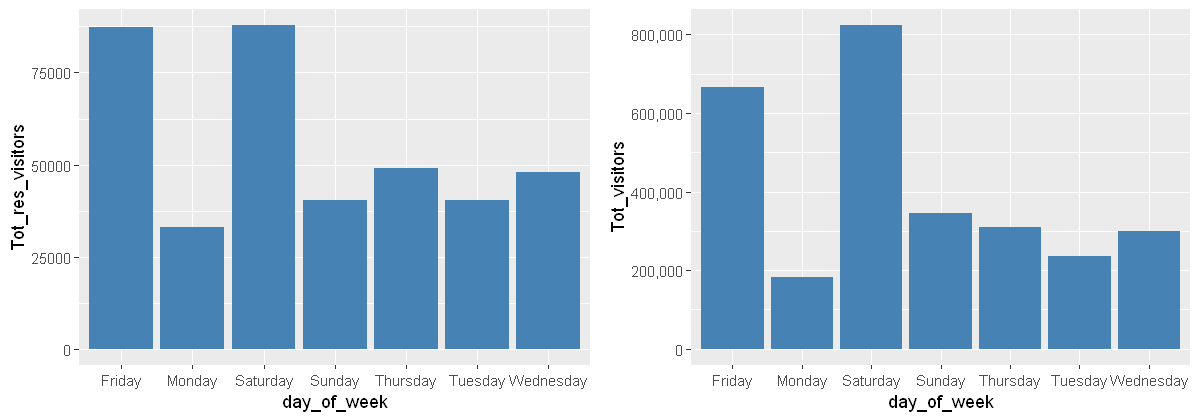

In [38]:
options(repr.plot.width = 10, repr.plot.height = 3.5)

plot1 <- ggplot(air_visit_data4 %>% group_by(day_of_week) %>% summarise(Tot_res_visitors = sum(reserved_visitors)), 
                aes(day_of_week, Tot_res_visitors)) +
         geom_bar(stat = 'identity' ,fill = 'steelblue') 
plot2 <- ggplot(air_visit_data4 %>% group_by(day_of_week) %>% summarise(Tot_visitors = sum(visitors)), 
                aes(day_of_week, Tot_visitors)) +
         geom_bar(stat = 'identity' ,fill = 'steelblue') +
         scale_y_continuous(labels = scales::comma) 

grid.arrange(plot1, plot2,nrow = 1, ncol = 2)

In [39]:
sort(table(air_visit_data4$air_store_id), decreasing = TRUE)


air_8093d0b565e9dbdf air_e55abd740f93ecc4 air_0a74a5408a0b8642 
                2229                 1875                 1818 
air_6d65542aa43b598b air_de692863bb2dd758 air_326ca454ef3558bc 
                1410                 1342                 1257 
air_03963426c9312048 air_483eba479dc9910d air_f911308e19d64236 
                1239                 1232                 1173 
air_3bb99a1fe0583897 air_24b9b2a020826ede air_5f6fa1b897fe80d5 
                1158                 1120                 1113 
air_6b15edd1b4fbb96a air_877f79706adbfb06 air_2cee51fa6fdf6c0d 
                1071                 1045                 1041 
air_96743eee94114261 air_2d3afcb91762fe01 air_a083834e7ffe187e 
                 980                  951                  930 
air_1408dd53f31a8a65 air_d6b3e67261f07646 air_af63df35857b16e6 
                 906                  898                  865 
air_7831b00996701c0f air_4092cfbd95a3ac1b air_3c05c8f26c611eb9 
                 837                  8

In [40]:
head(air_visit_data4)

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,day_of_week,holiday_flg,visit_datetime_air,reserve_datetime_air,unreserved_visitors,reserved_visitors,time_gap_in_hours,Time_of_day,visit_month,r_month_air
1007,air_35512c42db0868da,2016-02-27,6,Dining bar,TÅkyÅ-to Musashino-shi MidorichÅ,Saturday,No_holiday,2016-02-27 22:00:00,2016-02-27,-6,12,0,Night,February,February
3745,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Monday,No_holiday,2016-01-04 15:00:00,2016-01-04,59,2,0,Evening,January,January
3748,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Friday,No_holiday,2016-01-08 19:00:00,2016-01-06,18,3,48,Night,January,January
3749,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Saturday,No_holiday,2016-01-09 11:00:00,2016-01-06,56,1,72,Evening,January,January
3750,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Saturday,No_holiday,2016-01-09 11:00:00,2016-01-07,55,2,48,Evening,January,January
3751,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi MotoshirochÅ,Saturday,No_holiday,2016-01-09 11:00:00,2016-01-08,54,3,24,Evening,January,January


In [41]:
str(air_visit_data4)

'data.frame':	87181 obs. of  15 variables:
 $ air_store_id        : Factor w/ 312 levels "air_00a91d42b08b08d9",..: 64 292 292 292 292 292 292 292 292 292 ...
 $ visit_date          : Date, format: "2016-02-27" "2016-01-04" ...
 $ visitors            : int  6 61 21 57 57 57 57 57 57 57 ...
 $ air_genre_name      : Factor w/ 14 levels "Asian","Bar/Cocktail",..: 5 3 3 3 3 3 3 3 3 3 ...
 $ air_area_name       : Factor w/ 103 levels "ÅŒsaka-fu ÅŒsaka-shi ÅŒgimachi",..: 79 50 50 50 50 50 50 50 50 50 ...
 $ day_of_week         : Factor w/ 7 levels "Friday","Monday",..: 3 2 1 3 3 3 3 3 3 3 ...
 $ holiday_flg         : Factor w/ 2 levels "Holiday","No_holiday": 2 2 2 2 2 2 2 2 2 2 ...
 $ visit_datetime_air  : Factor w/ 4975 levels "2016-01-01 19:00:00",..: 621 17 59 67 67 67 69 69 70 71 ...
 $ reserve_datetime_air: POSIXct, format: "2016-02-27" "2016-01-04" ...
 $ unreserved_visitors : int  -6 59 18 56 55 54 55 55 55 55 ...
 $ reserved_visitors   : int  12 2 3 1 2 3 2 2 2 2 ...
 $ time_gap_in_

In [42]:
sort(table(air_visit_data4$air_genre_name), decreasing = TRUE)[1:5]


             Izakaya       Italian/French        Japanese food 
               31610                19697                 9727 
          Dining bar Yakiniku/Korean food 
                8039                 5616 

# Data Split

In [46]:
# since there is a random fluctuation after july to november, we are going to use the data after september 2016 for forecasting
# we are going to forecast the total visitors and average visitors count.
avg_visitors_data <- air_visit_data4 %>% filter(visit_date > '2016-11-01') %>% group_by(visit_date) %>% 
         summarise(avg_visitors = round(mean(visitors)))

In [47]:
train1 <- avg_visitors_data %>% filter(visit_date <= '2017-03-01')
test1 <- avg_visitors_data %>% filter(visit_date > '2017-03-01')

In [ ]:
str(test)

# ARIMA

In [49]:
arima_model1 <- arima(train1$avg_visitors, order=c(0,0,1), seasonal= list(order=c(1,0,0), period = 7)) # average visitors

In [50]:
library(tseries)


In [51]:
Diff <- diff(train1$avg_visitors, lag = 7)

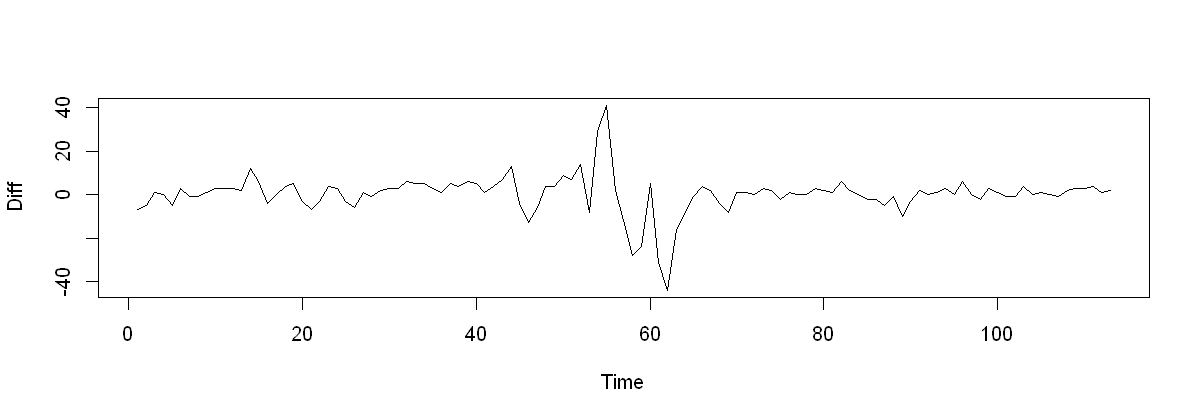

In [52]:
plot.ts(Diff)

In [53]:
adf.test(Diff)


	Augmented Dickey-Fuller Test

data:  Diff
Dickey-Fuller = -3.2957, Lag order = 4, p-value = 0.07545
alternative hypothesis: stationary


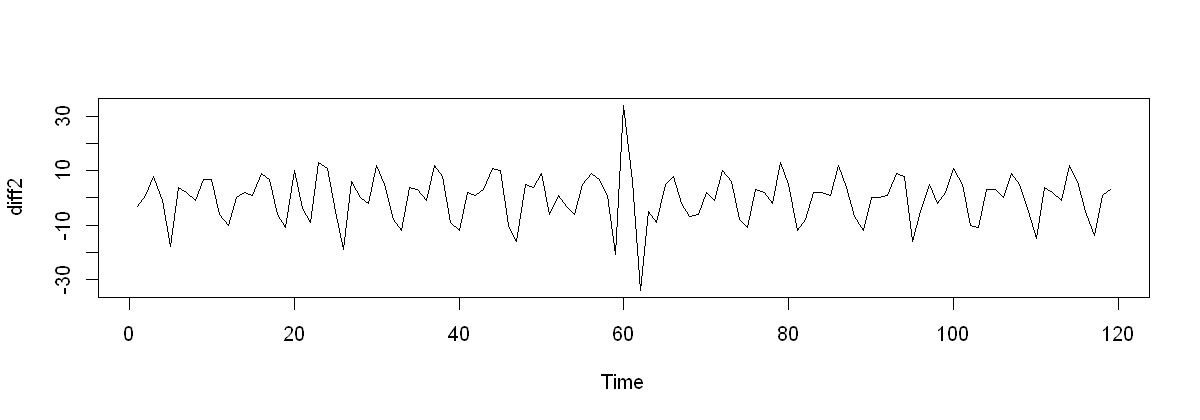

In [54]:
diff2 <- diff(train1$avg_visitors, lag = 1)
plot.ts(diff2)

In [55]:
adf.test(diff2)

Warning message in adf.test(diff2):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  diff2
Dickey-Fuller = -10.499, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


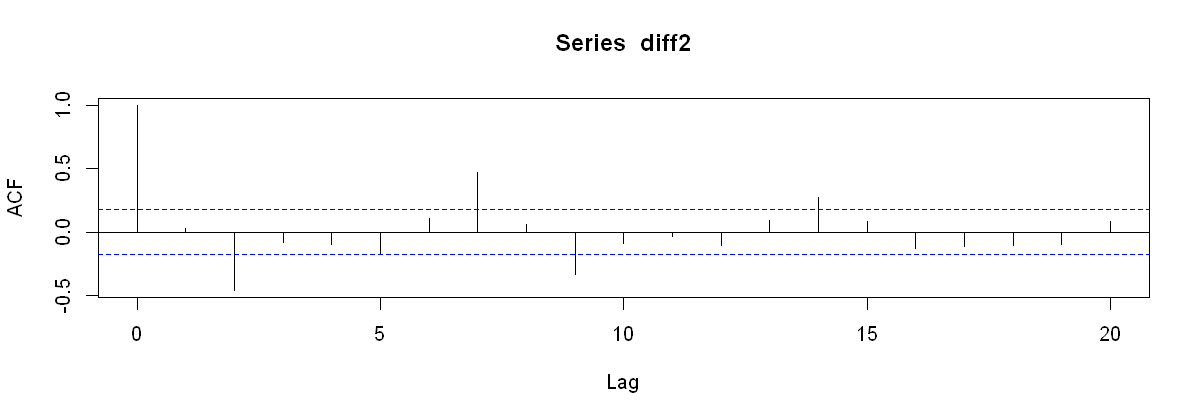

In [56]:
acf(diff2)

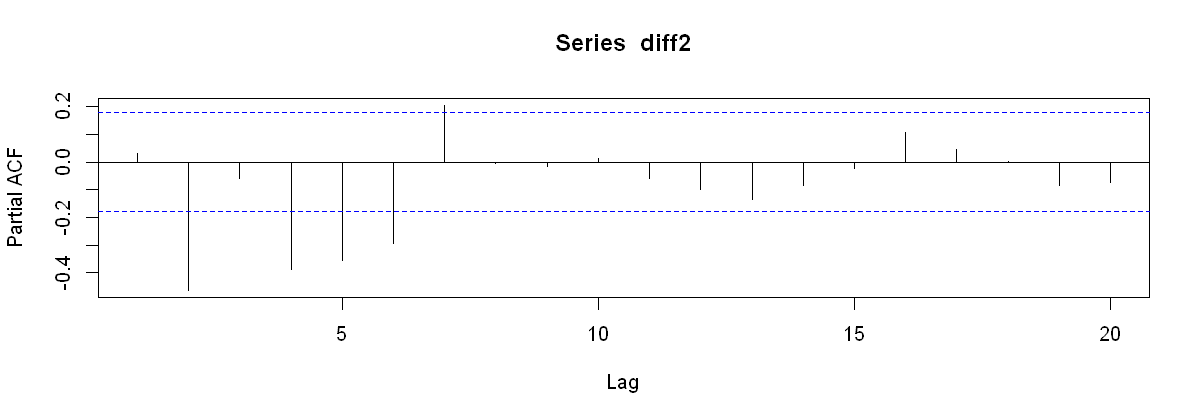

In [57]:
pacf(diff2)

In [58]:
arima.fit <- auto.arima(tsclean(ts(train1$avg_visitors, frequency = 7)),
                        stepwise = FALSE, approximation = FALSE)

In [59]:
AIC(arima.fit)

[1] 794.1785

In [60]:
summary(arima.fit)

Series: tsclean(ts(train1$avg_visitors, frequency = 7)) 
ARIMA(0,0,1)(1,0,0)[7] with non-zero mean 

Coefficients:
         ma1    sar1     mean
      0.6962  0.4405  30.4162
s.e.  0.0598  0.0832   1.6753

sigma^2 estimated as 41.27:  log likelihood=-393.09
AIC=794.18   AICc=794.53   BIC=805.33

Training set error measures:
                     ME     RMSE     MAE       MPE     MAPE      MASE
Training set 0.04002186 6.343709 4.22554 -3.767292 13.94488 0.8134344
                   ACF1
Training set 0.05449304


In [61]:
Box.test(arima.fit$residuals, type = "Ljung")


	Box-Ljung test

data:  arima.fit$residuals
X-squared = 0.36532, df = 1, p-value = 0.5456


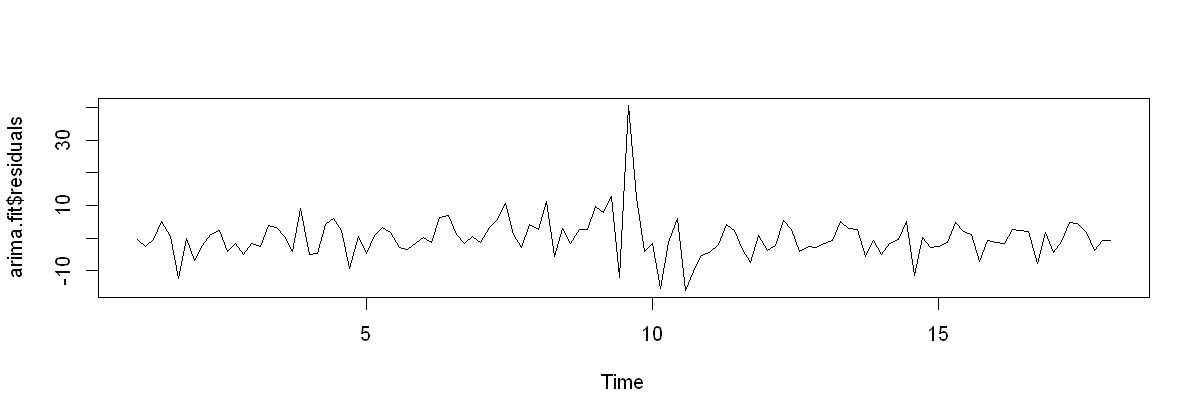

In [62]:
plot(arima.fit$residuals)

In [63]:
AIC(arima.fit)

[1] 794.1785

In [64]:
par(mfrow=c(2,1))

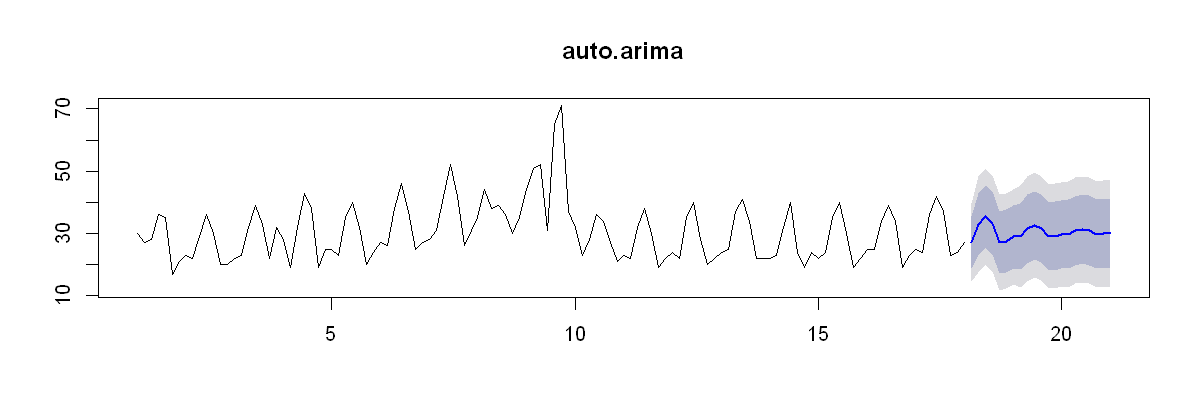

In [65]:
plot(forecast(arima.fit, h = 21), main = "auto.arima")

In [66]:
forecast(arima.fit, h = 21)

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
18.14286       27.15222 18.91886 35.38558 14.56038 39.74406
18.28571       32.87612 22.84397 42.90826 17.53328 48.21896
18.42857       35.51938 25.48724 45.55153 20.17654 50.86223
18.57143       33.31666 23.28452 43.34881 17.97382 48.65951
18.71429       27.14905 17.11690 37.18119 11.80620 42.49189
18.85714       27.58959 17.55744 37.62174 12.24675 42.93243
19.00000       28.91122 18.87908 38.94337 13.56838 44.25407
19.14286       28.97828 18.31056 39.64600 12.66341 45.29315
19.28571       31.49991 20.53739 42.46243 14.73419 48.26564
19.42857       32.66439 21.70187 43.62690 15.89866 49.43011
19.57143       31.69399 20.73147 42.65651 14.92826 48.45972
19.71429       28.97688 18.01436 39.93940 12.21116 45.74261
19.85714       29.17096 18.20844 40.13348 12.40524 45.93669
20.00000       29.75320 18.79068 40.71572 12.98747 46.51893
20.14286       29.78274 18.70438 40.86111 12.83984 46.72564
20.28571       30.89363 19.75955 42.0277

In [67]:
forecast

function (object, ...) 
UseMethod("forecast")
<bytecode: 0x000000004c032068>
<environment: namespace:forecast>

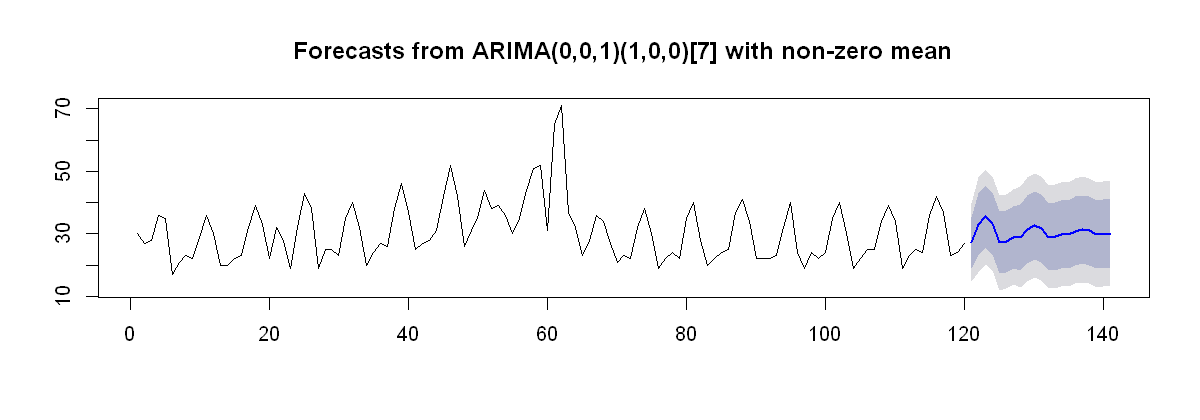

In [68]:
plot(forecast(arima_model1, h = 21))

In [72]:
accuracy(arima_model1)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.04002186,6.343709,4.22554,-3.767292,13.94488,0.6200238,0.05449304


# Exponential Smoothing

In [74]:
ses_model1 <- ets(train1$avg_visitors)

In [75]:
ses_model1

ETS(M,N,N) 

Call:
 ets(y = train1$avg_visitors) 

  Smoothing parameters:
    alpha = 0.8378 

  Initial states:
    l = 27.5771 

  sigma:  0.2721

     AIC     AICc      BIC 
1078.209 1078.416 1086.572 

In [76]:
fcast_ses_model1 <- forecast(ses_model1, h = 4)

In [77]:
summary(accuracy(fcast_ses_model1))

       ME                RMSE            MAE             MPE        
 Min.   :-0.01022   Min.   :8.932   Min.   :6.791   Min.   :-4.786  
 1st Qu.:-0.01022   1st Qu.:8.932   1st Qu.:6.791   1st Qu.:-4.786  
 Median :-0.01022   Median :8.932   Median :6.791   Median :-4.786  
 Mean   :-0.01022   Mean   :8.932   Mean   :6.791   Mean   :-4.786  
 3rd Qu.:-0.01022   3rd Qu.:8.932   3rd Qu.:6.791   3rd Qu.:-4.786  
 Max.   :-0.01022   Max.   :8.932   Max.   :6.791   Max.   :-4.786  
      MAPE            MASE             ACF1       
 Min.   :23.12   Min.   :0.9965   Min.   :0.1158  
 1st Qu.:23.12   1st Qu.:0.9965   1st Qu.:0.1158  
 Median :23.12   Median :0.9965   Median :0.1158  
 Mean   :23.12   Mean   :0.9965   Mean   :0.1158  
 3rd Qu.:23.12   3rd Qu.:0.9965   3rd Qu.:0.1158  
 Max.   :23.12   Max.   :0.9965   Max.   :0.1158  

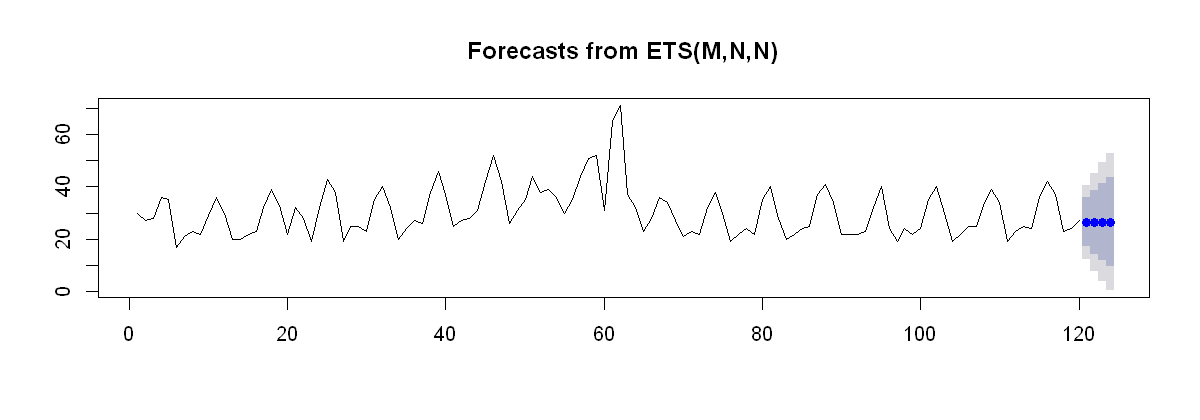

In [78]:
plot(fcast_ses_model1)

In [79]:
accuracy(fcast_ses_model1)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.01022291,8.931624,6.791438,-4.786338,23.11651,0.9965242,0.1158078


In [80]:
summary(ses_model1)

ETS(M,N,N) 

Call:
 ets(y = train1$avg_visitors) 

  Smoothing parameters:
    alpha = 0.8378 

  Initial states:
    l = 27.5771 

  sigma:  0.2721

     AIC     AICc      BIC 
1078.209 1078.416 1086.572 

Training set error measures:
                      ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.01022291 8.931624 6.791438 -4.786338 23.11651 0.9965242
                  ACF1
Training set 0.1158078


In [81]:
accuracy(ses_model1)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.01022291,8.931624,6.791438,-4.786338,23.11651,0.9965242,0.1158078


**since we have weekly trend, exponential smoothing performs very bad for average visitors forecasting....**

# HoltWinters method

In [85]:
hw2 <- HoltWinters(tsclean(ts(train1$avg_visitors, frequency = 7)))

In [86]:
pred1 <- predict(hw2, n.ahead = 50, prediction.interval = T, level = 0.95)

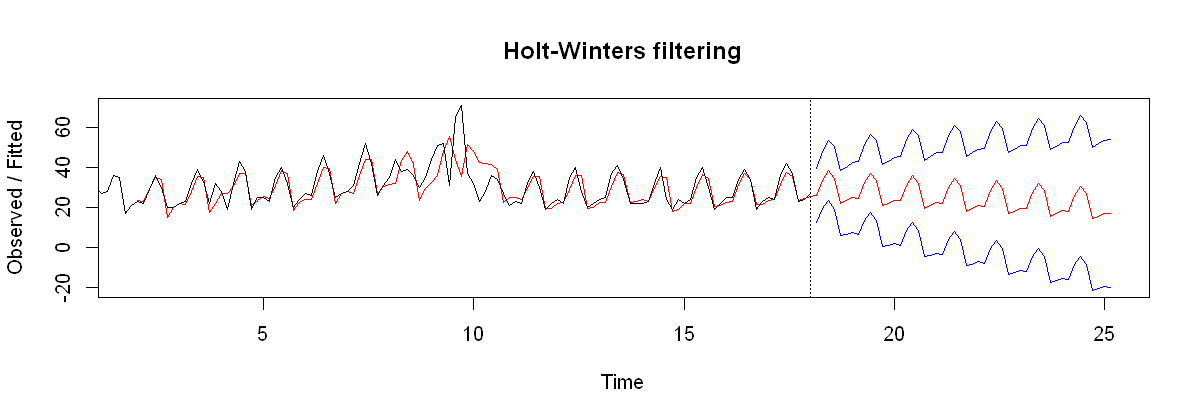

In [87]:
plot(hw2, pred1)

In [90]:
sse2 <- hw2$SSE
mse2 <- sse2/nrow(train1)
rmse2 <- sqrt(mse2)
cat('Root mean squared error is ', rmse2)

Root mean squared error is  6.63887

# Data split for tree

In [91]:
#average visitors
ts <- xts(avg_visitors_data[,2], order.by = avg_visitors_data$visit_date) # time series
target <- dailyReturn(ts)
predictor <- lag(target, k = 1)
avg_data <- cbind(target,predictor)
colnames(avg_data) <- c('target', 'predictor')
avg_data <- na.exclude(avg_data)
head(avg_data,3)
str(avg_data)

                target   predictor
2016-11-03 -0.10000000  0.00000000
2016-11-04  0.03703704 -0.10000000
2016-11-05  0.28571429  0.03703704

An 'xts' object on 2016-11-03/2017-04-22 containing:
  Data: num [1:171, 1:2] -0.1 0.037 0.2857 -0.0278 -0.5143 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "target" "predictor"
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
List of 1
 $ na.action: 'exclude' num 1


In [92]:
#average visitors
train_data <- window(avg_data, end = '2017-03-01')
test_data <- window(avg_data, start = '2017-03-02')

head(train_data,3)
head(test_data,3)

                target   predictor
2016-11-03 -0.10000000  0.00000000
2016-11-04  0.03703704 -0.10000000
2016-11-05  0.28571429  0.03703704

               target  predictor
2017-03-02 -0.1851852  0.1250000
2017-03-03  0.4545455 -0.1851852
2017-03-04  0.2500000  0.4545455

# Decision tree

In [93]:
avg_d_tree <- rpart(target ~ predictor, train_data) #average visitors model

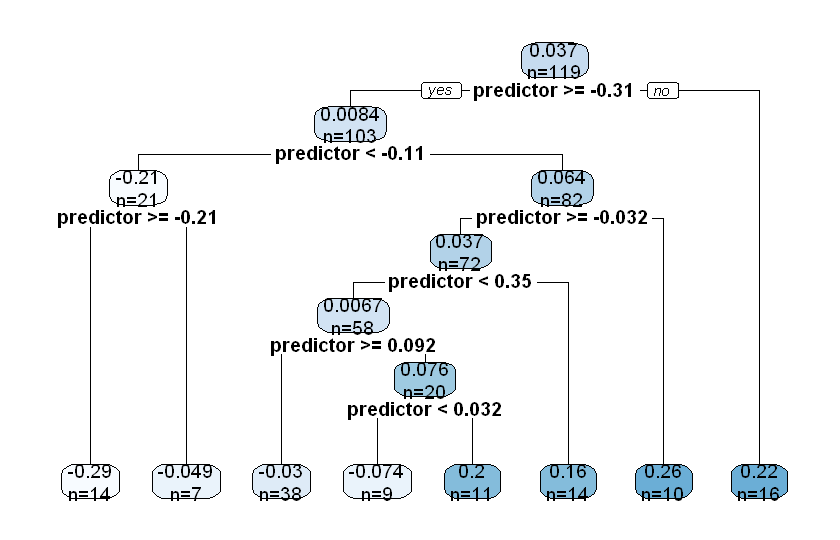

In [94]:
#avg visitors
options(repr.plot.width = 7, repr.plot.height = 4.5)
rpart.plot(avg_d_tree,extra = 1)

In [95]:
summary(avg_d_tree)

Call:
rpart(formula = target ~ predictor, data = train_data)
  n= 119 

          CP nsplit rel error    xerror      xstd
1 0.10318271      0 1.0000000 1.0086312 0.1552718
2 0.04866632      2 0.7936346 0.9437847 0.1530680
3 0.03016781      3 0.7449682 0.9285473 0.1417213
4 0.02995541      4 0.7148004 0.9046057 0.1396684
5 0.02882080      5 0.6848450 0.9046057 0.1396684
6 0.01000000      7 0.6272034 0.9149270 0.1440258

Variable importance
predictor 
      100 

Node number 1: 119 observations,    complexity param=0.1031827
  mean=0.03655012, MSE=0.07562345 
  left son=2 (103 obs) right son=3 (16 obs)
  Primary splits:
      predictor < -0.3107143  to the right, improve=0.06750184, (0 missing)

Node number 2: 103 observations,    complexity param=0.1031827
  mean=0.008390454, MSE=0.06676736 
  left son=4 (21 obs) right son=5 (82 obs)
  Primary splits:
      predictor < -0.1081395  to the left,  improve=0.1817149, (0 missing)

Node number 3: 16 observations
  mean=0.2178279, MSE=0.094668

In [96]:
# prediction
avg_test_pred = predict(avg_d_tree, test_data)
sse = sum((avg_test_pred - test_data$target)^2)
mse = sse/nrow(train_data)
rmse = sqrt(mse)
cat('Root mean squared error is',round(rmse,3))

Root mean squared error is 0.165

# Random forest

In [101]:
rf_avg_model <- randomForest(target ~ predictor, train_data, ntree = 500, nodesize = 2, replace = T) #average visitors model

In [102]:
rf_avg_model$predicted[1:10] # top 10 predicted value from train data

2016-11-03  2016-11-04  2016-11-05  2016-11-06  2016-11-07  2016-11-08 
 0.07741107 -0.25235392  0.21615934 -0.04597863  0.45047334  0.26607006 
 2016-11-09  2016-11-10  2016-11-11  2016-11-12 
-0.19643007 -0.12954242  0.43296046 -0.02919424

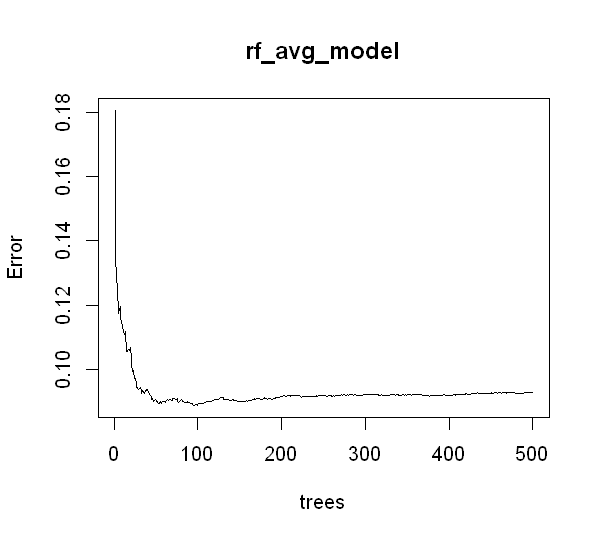

In [103]:
options(repr.plot.width = 5, repr.plot.height = 4.5)
plot1 <- plot(rf_avg_model)

In [104]:
rf_avg_model$mse[1:10] # mean squared error of first ten trees

[1] 0.1805814 0.1356363 0.1281903 0.1255911 0.1173313 0.1187430 0.1197085
 [8] 0.1161043 0.1149196 0.1138831

In [105]:
# average visitors
avg_test_pred1 = predict(rf_avg_model, test_data)
sse5 = sum((avg_test_pred1 - test_data$target)^2)
mse5 = sse5/nrow(train_data)
rmse5 = sqrt(mse5)
cat('Root mean squared error is', round(rmse5,3))

Root mean squared error is 0.178